In [2]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import time,sys,os
from sklearn.cluster import KMeans

today = datetime.date.today()
last = today +datetime.timedelta(days=-180)

os.makedirs('./csv/'+str(today),exist_ok = True)

# システムトレード：簡単バックテスト
https://qiita.com/innovation1005/items/236bc728c0db44ef9e55

In [3]:
TP = pd.read_csv('./csv/TOPIX_small1/Topix_small1.csv')
data =pd.DataFrame(TP)
stocks = [str(s)+".T" for s in data.code]
stocks.append("^N225")
tickers = yf.Tickers(" ".join(stocks))

In [6]:
closes= pd.read_csv('./csv/'+str(today)+'/closes_' + str(today)+'_6m_small498.csv')
closes['Date'] = pd.to_datetime(closes['Date'])
closes.set_index('Date',inplace=True)

In [16]:
tsd = closes.iloc[:,1]
tsd = pd.DataFrame(tsd)
tsd.columns =['Close']

,Close
Date,
2020-05-25,1987.306519
2020-05-26,1998.258667
2020-05-27,2004.232544
2020-05-28,2006.223755
2020-05-29,1998.258667
...,...
2020-11-18,2119.000000
2020-11-19,2117.000000
2020-11-20,2134.000000


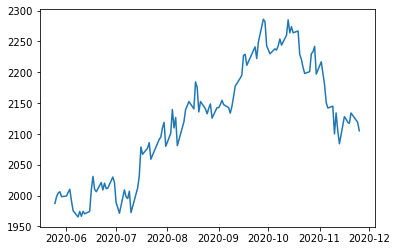

In [44]:
plt.plot(tsd)

# 損切なしの単純タイプ

In [10]:

def up_crossover_ma_two(tsd,window0,window9):
    y=pd.DataFrame(tsd).copy()
    y['pl']=0 #一日の損益を入れます。
    y['ma0']=y.Close.rolling(window0).mean().shift(1) #短い移動平均の計算
    y['ma9']=y.Close.rolling(window9).mean().shift(1) #長い移動平均の計算
    y=y.dropna(how='any')#数値の無いものが1つでもあればその行を削除します。
    #init----------------------------------
    n=0
    buy=0 #買った時の価格です。フラグの役割もしています。
    buyF=0 #買いシグナルのフラグ。
    sellF=0 #売りシグナルのフラグ
    size=0 #トレードできる資産の最大の単位数を示します。
    comm=0 #手数料を入れます。今回はゼロの設定です。
    for i in range(1,len(y)):
        c=y.Close.iloc[i] #その日の価格の取得
        c0=y.Close.iloc[i-1] #前日の価格の取得
        m0=y.ma0.iloc[i]
        m9=y.ma9.iloc[i]
        if buy!=0:
            y.iloc[i,1]=(c-c0)# pl
        if m0>m9:
            buyF=1
            sellF=0
        if m0<m9:
            sellF=1
            buyF=0
        if buyF==1 and buy==0:#entry long-position
            buy=c+c*comm*2
            y.iloc[i,1]=-c*comm*2
        if sellF==1 and buy!=0 and c>buy:#c>buyで利益だ出たときだけ利食います。
            buy=0
        buyF=0
        sellF=0
    return y

# 短いほうの移動平均を2日、長いほうの移動平均を7日にしてみます。


<AxesSubplot:xlabel='Date'>

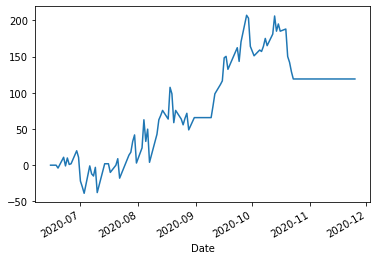

In [45]:
y=up_crossover_ma_two(tsd,5,15)
y.pl.cumsum().plot()

# 損切

In [23]:
def up_crossover_ma_two2(tsd,window0,window9):
    y=pd.DataFrame(tsd).copy(9)
    y['pl']=0
    y['ma0']=tsd.Close.rolling(window0).mean().shift(1)
    y['ma9']=tsd.Close.rolling(window9).mean().shift(1)
    y['siz']=0
    y=y.dropna(how='any')#数値の無いものが1つでもあればその行を削除します。
    #init----------------------------------
    n=0
    buy=0
    sell=0
    buyF=0
    sellF=0
    size=0
    comm=0
    j=0
    for i in range(1,len(y)):
        c=y.Close.iloc[i]
        c0=y.Close.iloc[i-1]
        m0=y.ma0.iloc[i]
        m9=y.ma9.iloc[i]
        y.iloc[i,4]=size
        if buy!=0:
            y.iloc[i,1]=(c-c0)*size# pl
        if m0>m9:
            buyF=1
            sellF=0
        if m0<m9:
            sellF=1
            buyF=0
        if buyF==1 and buy==0:#entry long-position
            buy=c+c*comm*2
            y.iloc[i,1]=-c*comm*2
            if j==0:
                pl0=c
                j=1
            cumpl=y.pl.cumsum().iloc[i]+pl0
            if cumpl>c:
                size=1
            else:
                size=cumpl/c
        if sellF==1 and buy!=0 and c>buy:#c>buyで利益だ出たときだけ利食います。
            buy=0
        buyF=0
        sellF=0
    return y

<AxesSubplot:xlabel='Date'>

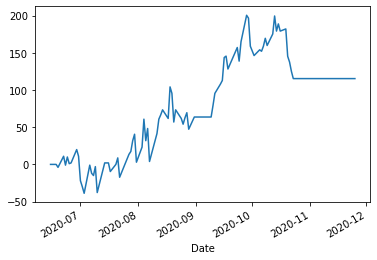

In [46]:
y=up_crossover_ma_two2(tsd,5,15)
y.pl.cumsum().plot()

<AxesSubplot:xlabel='Date'>

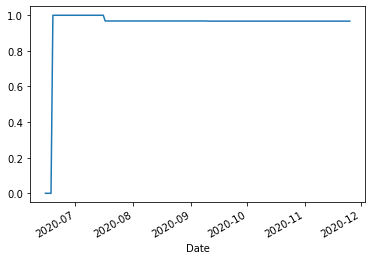

In [47]:
y.siz.plot()

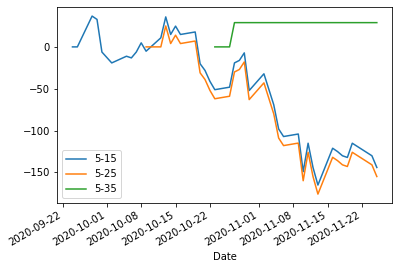

In [48]:
tsd0=tsd.loc['2020-09':'2020-12']

for s in range(5,15,15):
    for l in range(15,40,10):
        y=up_crossover_ma_two2(tsd0,s,l)
        y.pl.cumsum().plot(label=str(s)+'-'+str(l))
plt.legend()

# バックテストの時期の影響

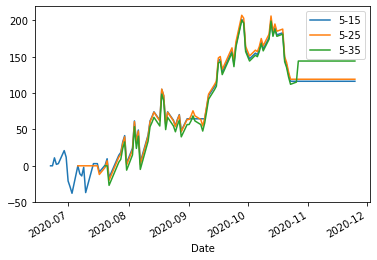

In [49]:
tsd0=tsd.loc['2020-06':'2020-12']

for s in range(5,15,15):
    for l in range(15,40,10):
        y=up_crossover_ma_two2(tsd0,s,l)
        y.pl.cumsum().plot(label=str(s)+'-'+str(l))
plt.legend()

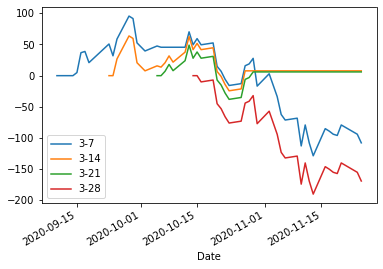

In [52]:
tsd0=tsd.loc['2020-09':'2020-12']

for s in range(3,7,7):
    for l in range(7,30,7):
        y=up_crossover_ma_two2(tsd0,s,l)
        y.pl.cumsum().plot(label=str(s)+'-'+str(l))
plt.legend()